# Plumed SVM Enhanced Sampling

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
import itertools    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import os

#XRD Ensemble

#28 4NPQ
#18 4HFI

In [2]:
residue_selection = 'resSeq 8 to 316'

In [3]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3','5NJY_F238L_pH70_md1',
                 '5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3','5NJY_I233T_pH70_md4',
                  '5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3','5NJY_F238LI233T_pH70_md1',
                  '5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3','5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3',
              '5NJY_F238L_pH46_md1','5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3','5NJY_I233T_pH46_md1',
                  '5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3','5NJY_F238LI233T_pH46_md1',
                  '5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3','4HFI_pH46_md1',
              '4HFI_pH46_md2','4HFI_pH46_md3','4HFI_F238L_pH46_md1',
                 '4HFI_F238L_pH46_md2','4HFI_F238L_pH46_md3','4HFI_I233T_pH46_md1',
                  '4HFI_I233T_pH46_md2','4HFI_I233T_pH46_md3','4HFI_F238LI233T_pH46_md1',
                  '4HFI_F238LI233T_pH46_md2','4HFI_F238LI233T_pH46_md3','4NPQ_pH70_md5',
              '4NPQ_pH70_md6','4NPQ_pH70_md7','4NPQ_F238L_pH70_md3',
                 '4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5','4NPQ_I233T_pH70_md3',
                  '4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5','4NPQ_F238LI233T_pH70_md3',
                  '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5']

In [4]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','traj_time']))
    return md_data

In [5]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note,location = '/media/scottzhuang/data/MD/',skip=10,md_data= md_data):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        if skip == 1:
            traj = md.load(location + traj_location,top= location + top_location,stride=10)
        else:
            traj = md.load(location + traj_location,top= location + top_location)
        print("In " + traj_note + ", simulation runs " + str(10 * traj.n_frames) + " ns.")
        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)

In [6]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = '/media/scottzhuang/data/MD/'
    skip=10
    notations = []
    increment = 0
    for traj_note in traj_notes:
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('md1') >= 0:
            notation = notation + 1
        if traj_note == '5NJY_I233T_pH70_md4' or traj_note == '4NPQ_pH70_md5' or  traj_note == '4NPQ_F238L_pH70_md3' or traj_note == '4NPQ_I233T_pH70_md3' or traj_note == '4NPQ_F238LI233T_pH70_md3':
            notation = notation + 1

        for frame in range(0,traj.n_frames):
            notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
        
    md_data['system'] = notations

In [7]:
md_data = create_md_dataframe()
create_metadata(md_data= md_data)
create_system_notation(md_data = md_data)

In 5NJY_pH70_md1, simulation runs 1030 ns.
In 5NJY_pH70_md2, simulation runs 750 ns.
In 5NJY_pH70_md3, simulation runs 810 ns.
In 5NJY_F238L_pH70_md1, simulation runs 540 ns.
In 5NJY_F238L_pH70_md2, simulation runs 680 ns.
In 5NJY_F238L_pH70_md3, simulation runs 720 ns.
In 5NJY_I233T_pH70_md4, simulation runs 730 ns.
In 5NJY_I233T_pH70_md2, simulation runs 590 ns.
In 5NJY_I233T_pH70_md3, simulation runs 820 ns.
In 5NJY_F238LI233T_pH70_md1, simulation runs 830 ns.
In 5NJY_F238LI233T_pH70_md2, simulation runs 800 ns.
In 5NJY_F238LI233T_pH70_md3, simulation runs 880 ns.
In 5NJY_pH46_md1, simulation runs 780 ns.
In 5NJY_pH46_md2, simulation runs 1060 ns.
In 5NJY_pH46_md3, simulation runs 1030 ns.
In 5NJY_F238L_pH46_md1, simulation runs 930 ns.
In 5NJY_F238L_pH46_md2, simulation runs 950 ns.
In 5NJY_F238L_pH46_md3, simulation runs 1090 ns.
In 5NJY_I233T_pH46_md1, simulation runs 810 ns.
In 5NJY_I233T_pH46_md2, simulation runs 870 ns.
In 5NJY_I233T_pH46_md3, simulation runs 980 ns.
In 5NJY_F

In [16]:
from msmbuilder.featurizer import ContactFeaturizer

In [36]:
contact_indice=[]
for i in itertools.product(np.arange(191,215),np.arange(215,243)):
    for chain in range(0,5):
        contact_indice.append([i[0] + chain * 311,i[1] + chain * 311])

In [37]:
feat =ContactFeaturizer(contact_indice, scheme='closest-heavy')

In [49]:
df = pd.DataFrame(feat.describe_features(top))['resids'].values

In [58]:
for feature in df:
    md_data[str(feature)] = 0

In [104]:
ind = 0
location = '/media/scottzhuang/data/MD/'
skip=10
for traj_note in traj_notes:
    top_location = traj_note + '/' + traj_note + ".protein.gro"
    traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
    traj = md.load(location + traj_location,top= location + top_location)
    df = pd.DataFrame(feat.partial_transform(traj))
    md_data.iloc[ind : ind + traj.n_frames , 5 : ] = df.values
#        md_data.iloc[]
    ind = ind + traj.n_frames
    print(ind)

103
178
259
313
381
453
526
585
667
750
830
918
996
1102
1205
1298
1393
1502
1583
1670
1768
1847
1942
2038
2148
2258
2365
2469
2570
2674
2777
2880
2983
3089
3190
3302
3386
3480
3585
3668
3767
3863
3952
4050
4155
4243
4335
4436


In [106]:
md_data.to_csv("glic_gating_contact.csv")

In [109]:
md_feature.columns

Index(['Unnamed: 0', 'MD_name', 'pH', 'replicate', 'traj_time', 'system',
       '[191 215]', '[502 526]', '[813 837]', '[1124 1148]',
       ...
       '[214 241]', '[525 552]', '[836 863]', '[1147 1174]', '[1458 1485]',
       '[214 242]', '[525 553]', '[836 864]', '[1147 1175]', '[1458 1486]'],
      dtype='object', length=3366)

Index(['[820 864]', '[818 864]', '[817 859]', '[816 859]', '[821 864]',
       '[506 553]', '[822 864]', '[211 231]', '[821 859]', '[503 543]'],
      dtype='object')


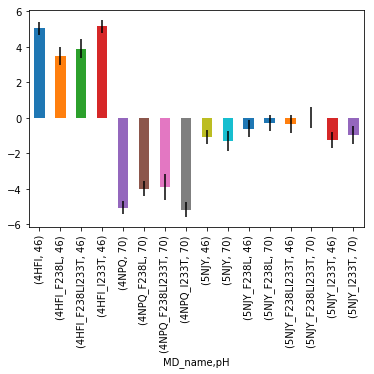

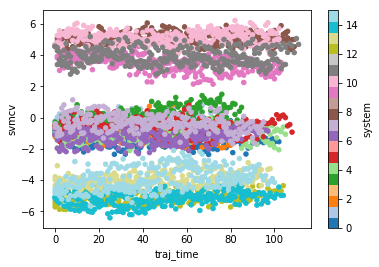

In [110]:
md_feature = pd.read_csv("glic_gating_contact.csv")
#md_feature = pd.read_csv("glic_gating.csv")
test_X = md_feature.drop(columns=['MD_name', 'pH', 'replicate', 'traj_time','system','Unnamed: 0'])
#scaler = StandardScaler()
#scaler.fit(test_X)
test_x_scaled = test_X

trainset = md_feature.drop(columns=['MD_name', 'pH', 'replicate', 'traj_time','Unnamed: 0'])

trainset = trainset[(trainset['system'] == 8) | (trainset['system'] == 12)]
trainset.loc[(trainset['system'] == 8),'system'] = 1
trainset.loc[(trainset['system'] == 12),'system'] = 0
trainset = trainset.reset_index()
trainset = trainset.drop(['index'],axis=1)
Y = trainset.as_matrix()[:,0]
X = trainset.as_matrix()[:,1:]
#X = scaler.fit_transform(trainset.as_matrix()[:,1:])
clf = SVC(kernel="linear")
clf.fit(X,Y)

#test_x_scaled = scaler.transform(test_X)

b=clf.decision_function(test_x_scaled)/np.linalg.norm(clf.coef_)
#b, index = reject_outliers(b)
#b_stand = (b - b.min()) / (b.max() - b.min())
md_feature['svmcv'] = b
print(test_X.columns[np.argsort(-np.abs(clf.coef_[0]))[:10]])
group = md_feature.groupby(['MD_name','pH'])['svmcv']
mean = group.mean()
errors = group.std()
ax = plt.subplot()
mean.plot.bar(yerr=errors,ax=ax)
plt.show()
ax = plt.subplot()
md_feature.plot(kind="scatter",x="traj_time",y="svmcv",c='system',ax=ax,colormap='Vega20')
plt.show()

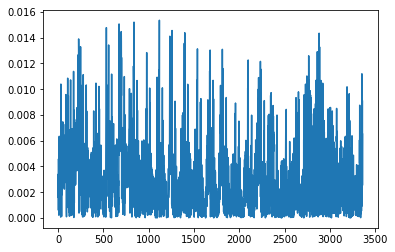

In [126]:
plt.plot(np.abs(clf.coef_[0]))

In [133]:
clf.coef_.shape[1]

3360

In [135]:
np.argsort(-np.abs(clf.coef_))[0][:100]

array([1117,  837,  672,  532, 1257,  696, 1397, 2880, 1232,  226,  695,
        697, 1392,  557,  836,  247, 2885, 1537, 1812,  691, 1677,  227,
       2860, 2865,  977,  246, 1252,  221,  694, 2765,  699, 2097, 2232,
        831, 1817, 2237, 1112, 1672,  170,  689, 3352,  590,  686,  277,
        692,  677, 2745,  236,  241,  730, 1092, 2212,  105,  832,  137,
       1532, 2770, 1251, 2845, 1710, 2900,  870, 2870,  248, 2895, 2875,
       1256,  417, 2920,   30, 2730, 1430,  683,  310,  537, 2855,  251,
       1792,  450, 3188,  685, 2915, 1150, 1010, 2092,  556,  787, 2210,
        687, 1237,  688, 2905, 2780, 2652, 1435, 2850, 2350,  807, 3212,
         85])

In [136]:
clf.coef_[0]

array([-0.00275598, -0.00158817, -0.00340616, ...,  0.00912577,
        0.00253444,  0.00651109])

In [137]:
np.argsort(-np.abs(clf.coef_))[0][:100]

array([1117,  837,  672,  532, 1257,  696, 1397, 2880, 1232,  226,  695,
        697, 1392,  557,  836,  247, 2885, 1537, 1812,  691, 1677,  227,
       2860, 2865,  977,  246, 1252,  221,  694, 2765,  699, 2097, 2232,
        831, 1817, 2237, 1112, 1672,  170,  689, 3352,  590,  686,  277,
        692,  677, 2745,  236,  241,  730, 1092, 2212,  105,  832,  137,
       1532, 2770, 1251, 2845, 1710, 2900,  870, 2870,  248, 2895, 2875,
       1256,  417, 2920,   30, 2730, 1430,  683,  310,  537, 2855,  251,
       1792,  450, 3188,  685, 2915, 1150, 1010, 2092,  556,  787, 2210,
        687, 1237,  688, 2905, 2780, 2652, 1435, 2850, 2350,  807, 3212,
         85])

In [142]:
df = df1.iloc[np.argsort(-np.abs(clf.coef_))[0]][:10]

In [143]:
from tica_metadynamics.pyplumed import render_df
from tica_metadynamics.pyplumed import render_meta 
from jinja2 import Template
from sklearn.utils.validation import check_is_fitted

In [144]:
plumed_matheval_template = Template("MATHEVAL ARG={{arg}} FUNC={{func}} LABEL={{label}} PERIODIC={{periodic}} ")

plumed_combine_template = Template("COMBINE LABEL={{label}} ARG={{arg}} COEFFICIENTS={{coefficients}} "+\
                                    "PERIODIC={{periodic}} ")
def render_svm(clf=None, input_prefix="f0", output_prefix="l"):
    if clf is None or check_is_fitted(clf,attributes=["coef_","intercept_"]):
        raise ValueError("Need a fitted Sklearn SVM object")
    else:
        n_args = 10
        output = []
        arg_list=",".join(["%s_%d"%(input_prefix,i) for i in np.argsort(-np.abs(clf.coef_))[0][:10]])
        coeff = ",".join([str(clf.coef_[0][i]) for i in np.argsort(-np.abs(clf.coef_))[0][:10]])
        w_norm = np.linalg.norm(clf.coef_)
        
        output.append(plumed_combine_template.render(label="%s_0"%output_prefix,
                                      arg=arg_list,
                                      coefficients=coeff,
                                      periodic="NO")+"\n")
        
        func="(x+%s)/%s"%(str(clf.intercept_[0]),str(w_norm))
        
        output.append(plumed_matheval_template.render(label="%s_1"%output_prefix,
                                      arg="l_0",
                                      func=func,
                                      periodic="NO")+"\n")        
        
    return ''.join(output)
        
        

In [120]:
top = md.load('/media/scottzhuang/data/MD/4NPQ_pH70_md5/4NPQ_pH70_md5.protein.gro')
df1 = pd.DataFrame(feat.describe_features(top))

In [149]:
total_out=[]
total_out.extend("RESTART\n")
total_out.extend(render_df(df))
total_out.extend(render_svm(clf))
total_out.extend(render_meta.render_metad_code("l_1",biasfactor=6,sigma=0.25))
total_out.extend(render_meta.render_metad_bias_print("l_1,metad.bias"))

In [150]:
text_file = open("plumed.dat", "w")
for item in total_out:
  text_file.write("%s" % item)
text_file.close()

In [151]:
print("".join(total_out))

RESTART
DISTANCES GROUPA=14599,14601,14603,14606,14608,14609,14610,14614,14615,14616,14620,14621 GROUPB=15398,15399,15402,15405,15408,15410,15411 MIN={BETA=20} LABEL=closest-heavy_820_864

DISTANCES GROUPA=14553,14555,14557,14559,14560,14561,14565,14568,14569,14570,14574,14575 GROUPB=15398,15399,15402,15405,15408,15410,15411 MIN={BETA=20} LABEL=closest-heavy_818_864

DISTANCES GROUPA=14539,14541,14543,14546,14547,14548,14551,14552 GROUPB=15310,15312,15314,15316,15317,15318,15322,15323,15324,15328,15329 MIN={BETA=20} LABEL=closest-heavy_817_859

DISTANCES GROUPA=14525,14526,14529,14532,14535,14537,14538 GROUPB=15310,15312,15314,15316,15317,15318,15322,15323,15324,15328,15329 MIN={BETA=20} LABEL=closest-heavy_816_859

DISTANCES GROUPA=14622,14623,14626,14629,14632,14634,14635 GROUPB=15398,15399,15402,15405,15408,15410,15411 MIN={BETA=20} LABEL=closest-heavy_821_864

DISTANCES GROUPA=8985,8987,8989,8992,8993,8994,8997,8998 GROUPB=9844,9845,9848,9851,9854,9856,9857 MIN={BETA=20} LABEL=clos